<a href="https://colab.research.google.com/github/notanumber-sys/dd2365-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Surface Waves in Steady State Shallow Flow by Navier-Stokes Equations**
**Ludwig Karlsson**, based on template by **Johan Hoffman**.

# **Set up environment**

In [94]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Method**

**Launch Options**

Change the value of the launch configurator option to choose which experiment to run.

In [95]:
# Experiment
# 0: Closed tub experiment
# 1: Type 1 flow
# 2: Type 2 flow
# 3: Type 3 flow
# 4: Type 4 flow
# 5: Type 3 flow alt.

launch_configuration = 0

# Define rectangular domain 
L = 10
H = 1

# bottom shape parameters
B0 = H/10
r = L/6

# initial wave shape
wave_epsilon = H/2
wave_width = L/10
apply_initial_surface_deformation = False

# mesh resolution
resolution = 12

# inflow velocity (for open experiments)
U = 1.2

# choose boundary conditions
closed = False

# for outflow, the goal is to be able to expell excess volume if necessary
use_velocity_limits = False

if launch_configuration == 0:   # closed tub experiment
    closed = True
    time_step_size_quotient = 20.0
    T = 5.0

    # wave:
    wave_shape = Expression("H + weps*exp(-pow(x[0] - L/2, 2)/(ww*ww))", H=H, weps=wave_epsilon, L=L, ww=wave_width, degree=2)
    wave_shape_displacement = Expression(("0", "(weps*exp(-pow(x[0] - L/2, 2)/(ww*ww)))*(x[1] > (H - EH))*((x[1] - H + EH)/EH)"), H=H, weps=wave_epsilon, L=L, ww=wave_width, EH=effective_height, degree=2)
    apply_initial_surface_deformation = True
elif launch_configuration == 1: # type 1 flow
    time_step_size_quotient = 20.0
    T = 5.0

    # flat:
    wave_shape = Expression("H", H=H, degree=2)
elif launch_configuration == 2: # type 2 flow
    U = 4.8
    time_step_size_quotient = 40.0
    T = 2.9

    # flat:
    wave_shape = Expression("H", H=H, degree=2)
elif launch_configuration == 3: # type 3 flow
    B0 = H/3
    time_step_size_quotient = 30.0
    T = 0.55
    
    use_velocity_limits = True
    max_velocity = 1.2*U
    min_velocity = 0.8*U

    # inverted wave:
    wave_shape = Expression("H - weps*exp(-pow(x[0] - L/2 - 1, 2)/(ww*ww))", H=H, weps=H/3, L=L, ww=wave_width, degree=2)
    wave_shape_displacement = Expression(("0", "-(weps*exp(-pow(x[0] - L/2 - 1, 2)/(ww*ww)))*(x[1] > (H - EH))*((x[1] - H + EH)/EH)"), H=H, weps=H/3, L=L, ww=wave_width, EH=effective_height, degree=2)
    apply_initial_surface_deformation = True
elif launch_configuration == 4: # type 4 flow
    B0 = H/5
    U = 3.0
    time_step_size_quotient = U*10
    T = 2.9
    
    use_velocity_limits = True
    max_velocity = 2*U
    min_velocity = 1.5*U

    # negative sigmoid:
    wave_shape = Expression("H + 1/(1 + exp(2*(x[0] - 5)))", H=H, degree=2)
    wave_shape_displacement = Expression(("0", "(1/(1 + exp(2*(x[0] - 5))))*(x[1] > (H - EH))*((x[1] - H + EH)/EH)"), H=H, weps=wave_epsilon, L=L, ww=wave_width, EH=effective_height, degree=2)
    apply_initial_surface_deformation = True
elif launch_configuration == 5: # potentially type 3
    U = 2.4
    time_step_size_quotient = U*10
    T = 3.0

    # flat
    wave_shape = Expression("H", H=H, degree=2)

effective_height = H - B0



**Define domain and mesh**

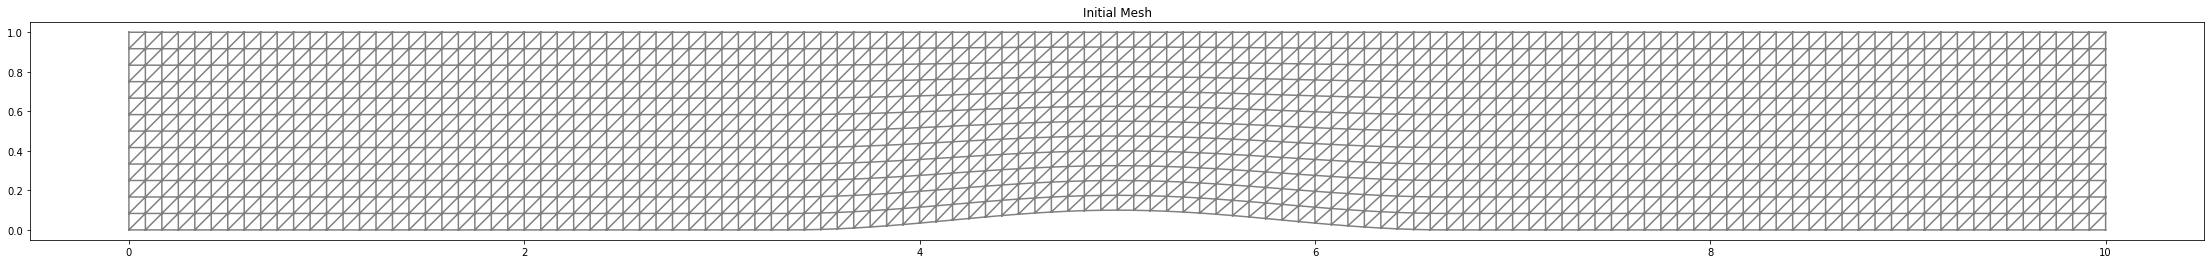

In [96]:

# Define bump
bottom_shape = Expression("B0*pow(cos(pi*(x[0] - L/2)/(2*r)), 2.0)*(abs(x[0] - L/2) < r)", B0=B0, L=L, r=r, degree=2)
shape_displacement = Expression(("0", "(B0*pow(cos(pi*(x[0] - L/2)/(2*r)), 2.0)*(abs(x[0] - L/2) < r))*((H - x[1])/H)"), B0=B0, L=L, r=r, H=H, degree=2)

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        if on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and x[1] <= 1.1*B0:
            return True
        if near(x[1], 0.0) and (near(x[0], 0.0) or near(x[0], L)):
            return True
        return False

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], wave_shape(x))
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh
delta_x = 1/resolution
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)

ALE.move(mesh, shape_displacement)
# displace for initial wave shape
if apply_initial_surface_deformation:
    ALE.move(mesh, wave_shape_displacement)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure(figsize=(40, 4))
plot(mesh, title="Initial Mesh")
plt.show()

**Define finite element approximation spaces**

In [97]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [98]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        if on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and x[1] <= 1.1*B0:
            return True
        if near(x[1], 0.0) and (near(x[0], 0.0) or near(x[0], L)):
            return True
        return False

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and x[1] > 1.1*B0

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()

# in flow
Vdot = wave_shape(0.0)*U

class InVelocityExpression(UserExpression):
    def eval(self, value, x):
        K = Vdot/self.h
        value[0] = K

    def value_shape(self):
        return ()
uin = InVelocityExpression()
uin.h = wave_shape(0.0)

class OutVelocityExpression(UserExpression):
    def eval(self, value, x):
        K = Vdot/self.h

        if use_velocity_limits:
            if K < min_velocity:
                K = min_velocity
            elif K > max_velocity:
                K = max_velocity
        value[0] = K

    def value_shape(self):
        return ()
uout = OutVelocityExpression()
uout.h = H

if closed:
    bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
    bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
    bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
    bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)

    bcp0 = DirichletBC(Q, 0.0, dbc_upper)
    
    bcu = [bcu_left0, bcu_right0, bcu_low0, bcu_low1]
    bcp = [bcp0]
else:
    bcu_left0 = DirichletBC(V.sub(0), uin, dbc_left)
    bcu_right0 = DirichletBC(V.sub(0), uout, dbc_right)
    bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
    bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)

    bcp0 = DirichletBC(Q, 0.0, dbc_upper)

    bcu = [bcu_left0, bcu_right0, bcu_low0, bcu_low1]
    bcp = [bcp0]


# **Results**

**Define flow parameters**

In [99]:
# Set viscosity (water)
nu = 1.0e-6 # m²/s
rho = 1e3   # kg/m³

# set gravity
g = 9.81    # m/s²
f = Expression(("0", "-g"), g=g, degree=2);

**Initial Conditions**

In [100]:
class InitialPressureExpression(UserExpression):
  def eval(self, value, x):
    value[0] = (wave_shape(x) - x[1])*g*rho

  def value_shape(self):
    return ()

class InitialVelocityExpression(UserExpression):
  def eval(self, value, x):
    value[0] = uin(x[0], x[1])*(wave_shape(0.0))/(wave_shape(x[0]) - bottom_shape(x[0]))
    value[1] = 0.0

  def value_shape(self):
    return (2,)

u_init = InitialVelocityExpression()
p_init = InitialPressureExpression()

**Define method parameters**

In [101]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

class DisplacementExpression(UserExpression):
    def set_md(self, displacement):
        if displacement == None:
            self.mesh_displacement = None
        else:
            self.mesh_displacement = interpolate(displacement, V)
            self.mesh_displacement.set_allow_extrapolation(True)
    
    def eval(self, value, x):
        if self.mesh_displacement is None:
            value[0] = 0.0
            value[1] = 0.0
        else:
            result = self.mesh_displacement(x[0], x[1])
            value[0] = result[0]
            value[1] = result[1]

    def value_shape(self):
        return (2,)
w = DisplacementExpression()
w.set_md(None)

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length
dt = 0.5*mesh.hmin() /time_step_size_quotient

**Define variational problem**

In [102]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*(um1-w/dt), v)*dx \
    - p1*div(v)*dx \
    + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*(um1-w/dt) + (1/rho)*grad(p1), grad(v)*(um1-w/dt))*dx \
    + d2*div(um)*div(v)*dx \
    - inner(f, v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*(um1-w/dt) + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Set plotting variables and open export files**

In [103]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 20

# Time data 
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Initial Pressure
Initial Velocity
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.002275199290795325
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 


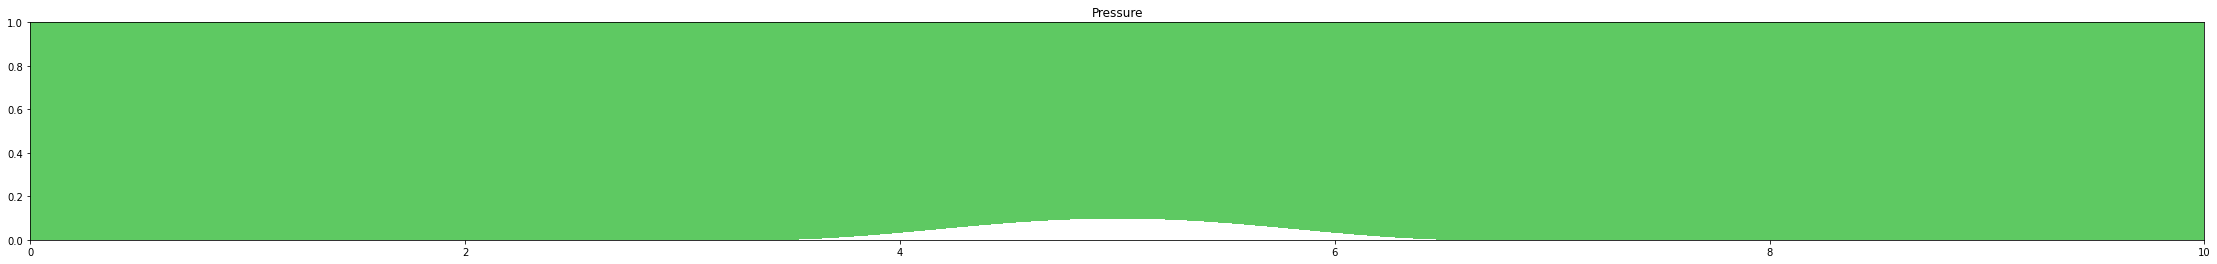

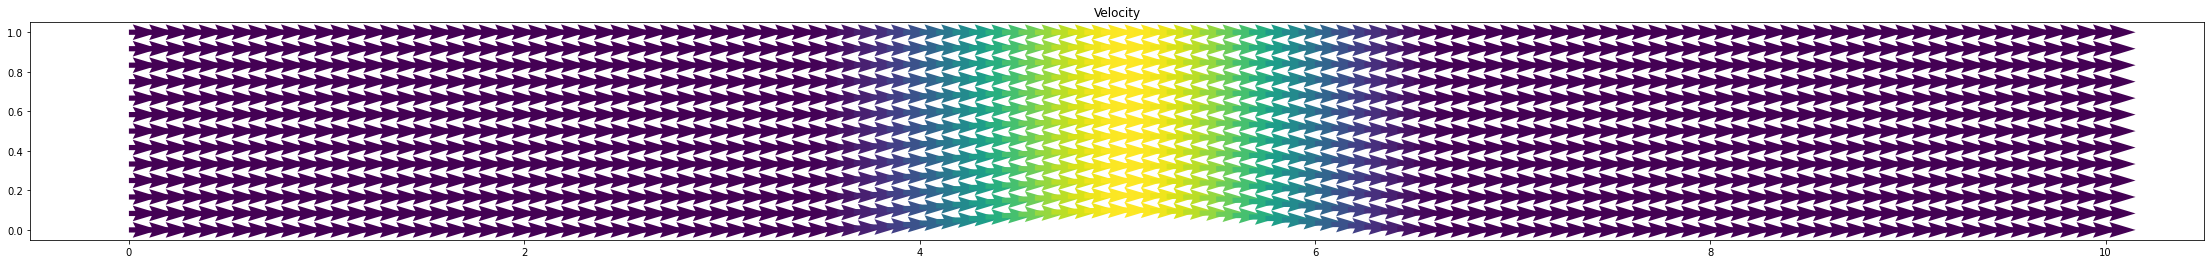

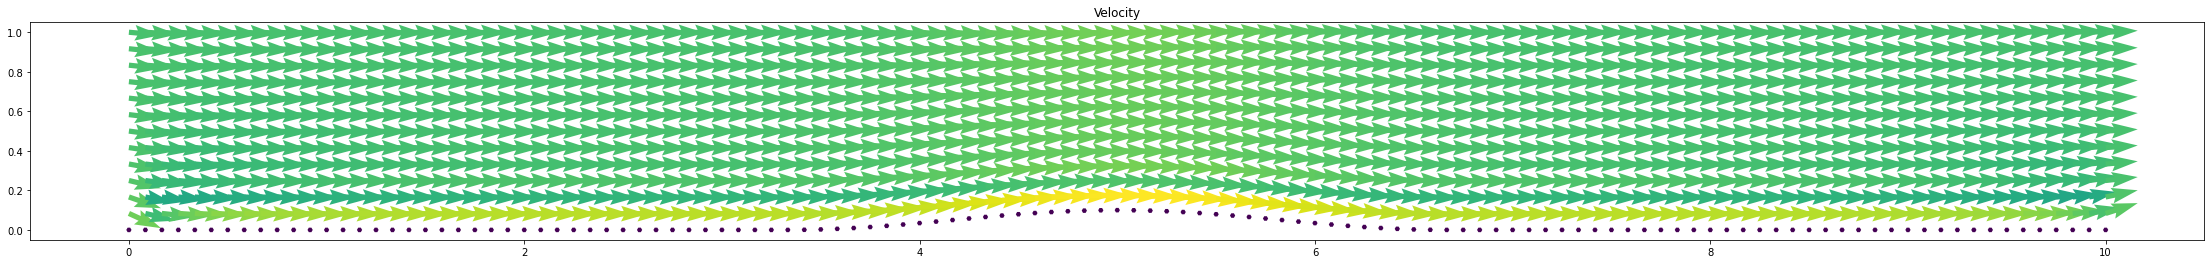

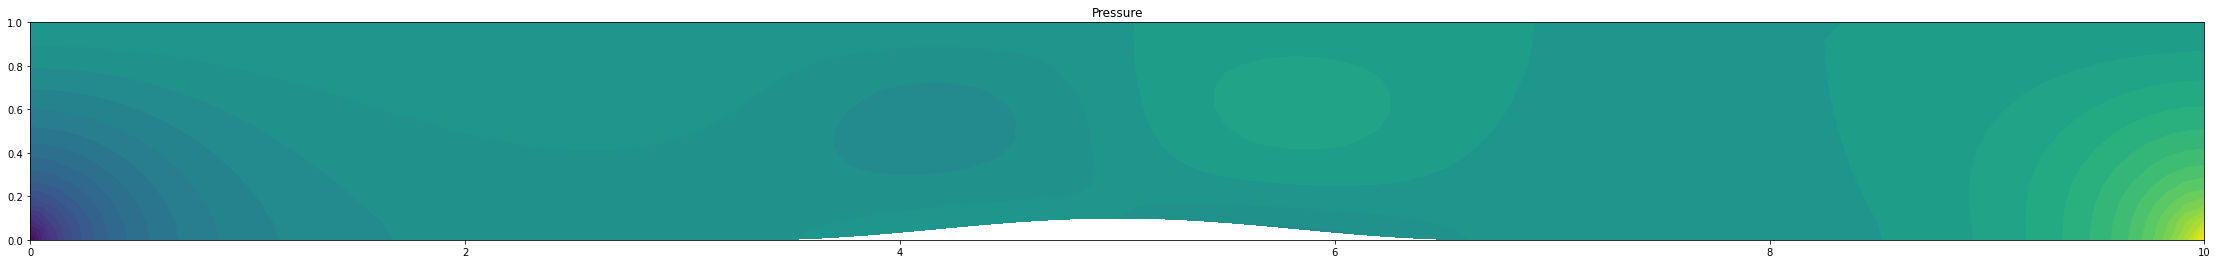

New Mesh:
Time t = 0.00455039858159065
0.9995100282866001 0.9996408408308559 0.9995583575656267 0.9995942507730994 0.9996012532860296 0.99962223794713 0.9996422148999133 0.9996638887088823 0.9996852895259746 0.9997061093994577 0.9997258295433279 0.9997442158251781 0.9997611238429407 0.9997765120276758 0.9997903989550699 0.999802845894717 0.9998139387905827 0.9998237765740777 0.9998324624719014 0.9998400983704886 0.9998467811751764 0.9998526005041901 0.9998576373200092 0.9998619632250236 0.9998656400153525 0.9998687192891244 0.9998712419765569 0.99987323763365 0.9998747232345732 0.9998757012918016 0.9998761569396276 0.9998760534636839 0.9998753256985404 0.9998738706030521 0.9998715335851822 0.9998680881714769 0.9998632051832463 0.9998564033545208 0.9998469552864805 0.9998337520518747 0.9998144075354501 0.9997869307526528 0.9997530849585755 0.9997163417050502 0.9996792246673684 0.9996436902204838 0.9996113410450751 0.9995835540265137 0.9995615201530833 0.9995462560518624 0.99953859544338

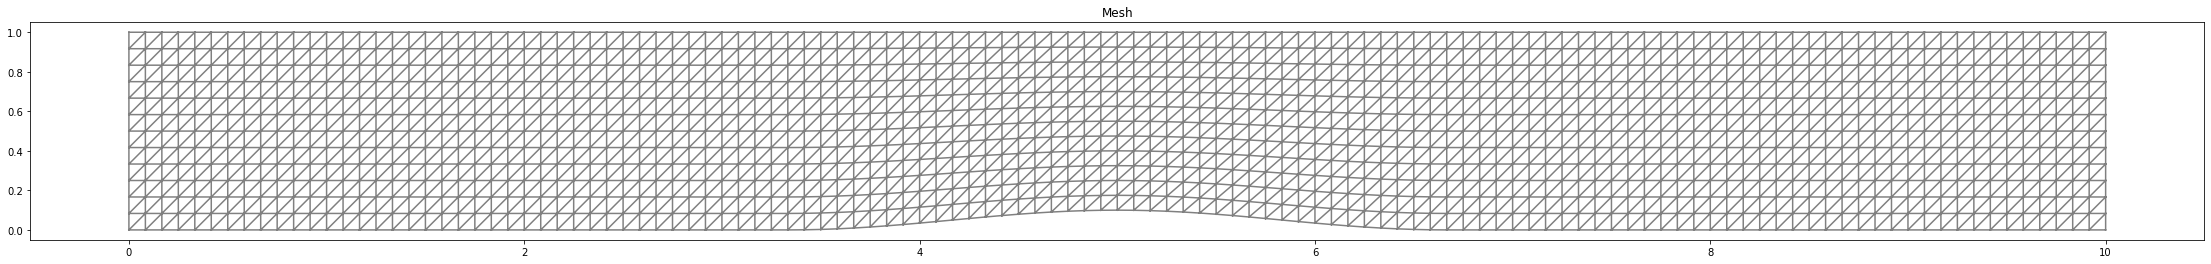

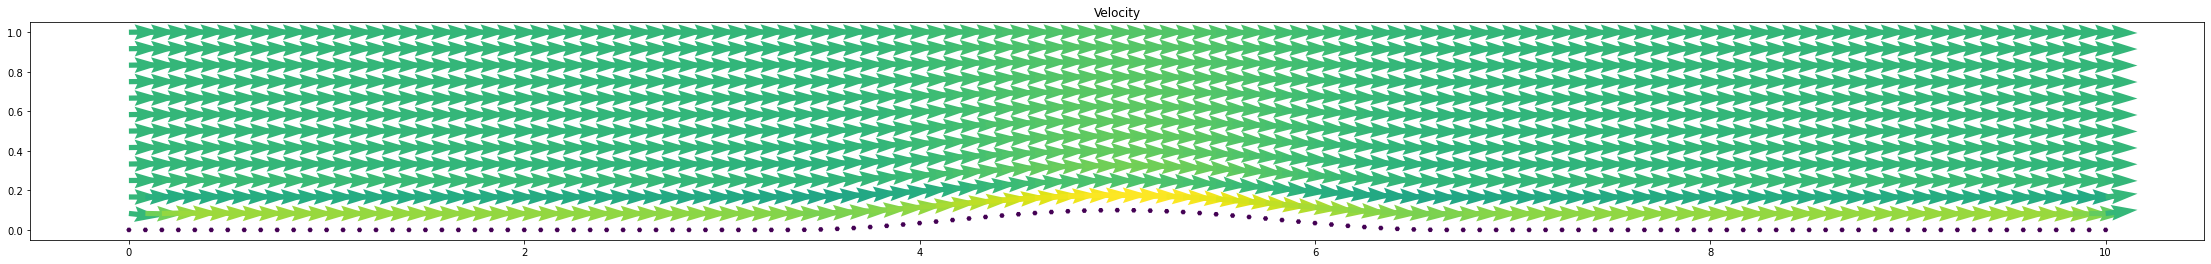

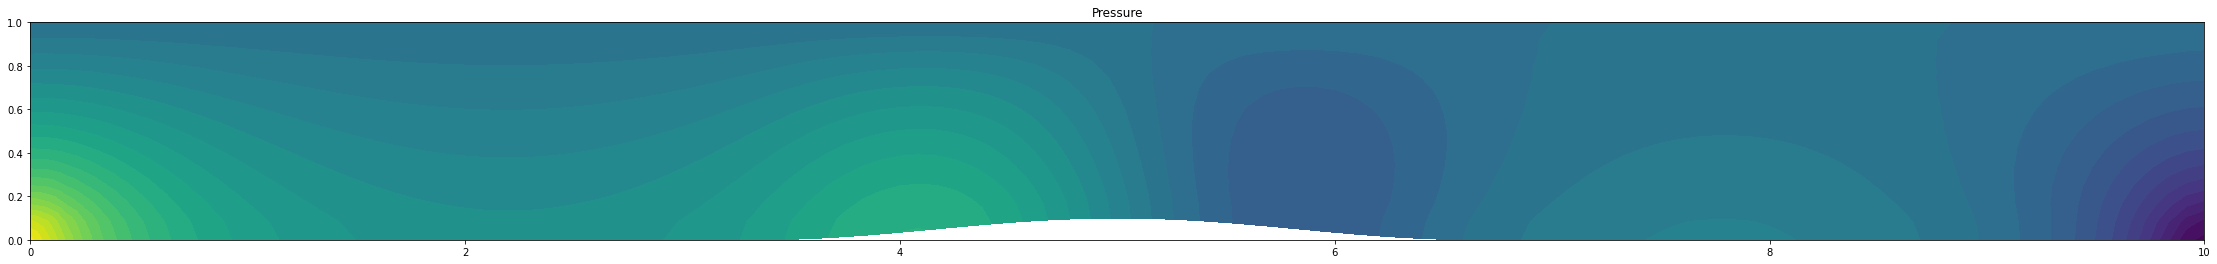

New Mesh:
Time t = 0.006825597872385975
0.999582341399072 0.9996795257815365 0.9996388071516519 0.9996556937130461 0.9996687876664972 0.9996849668900395 0.9997027763854129 0.9997207655180801 0.9997385523659497 0.9997554895210541 0.999771329150208 0.999785882695007 0.9997991036561389 0.9998110113673713 0.9998216788507704 0.9998312067070094 0.9998397103676675 0.9998473096166272 0.9998541229772124 0.9998602640523737 0.9998658395679613 0.9998709487390789 0.9998756833638432 0.9998801278937817 0.9998843597261512 0.9998884496387329 0.9998924620034882 0.9998964540573178 0.9999004743701091 0.999904560253264 0.9999087338577134 0.9999129952195842 0.9999173127122559 0.999921608006269 0.9999257347722696 0.9999294478912658 0.9999323580220535 0.999933863213628 0.9999330263823036 0.9999284038626537 0.9999162019974657 0.9998928670438988 0.99986100425487 0.999825541271154 0.9997892901516878 0.9997541941544956 0.9997217230936086 0.9996930651651269 0.9996692022430811 0.9996509484032904 0.9996389677295028 

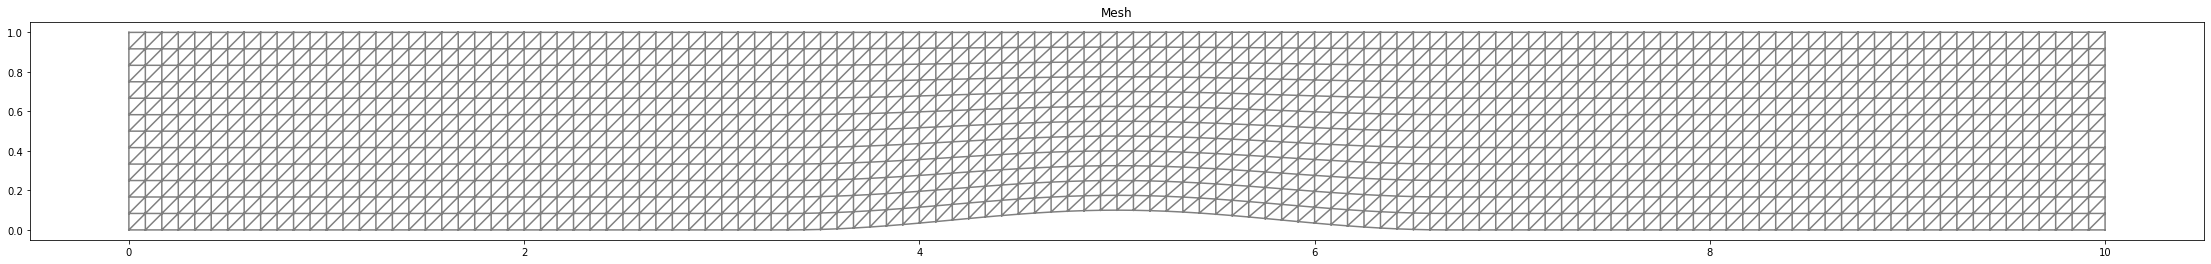

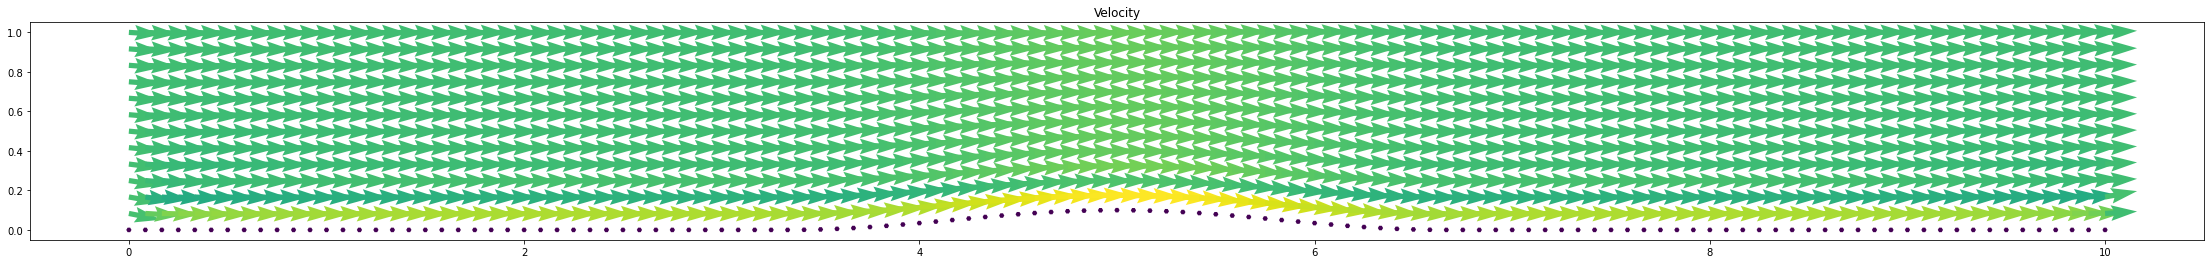

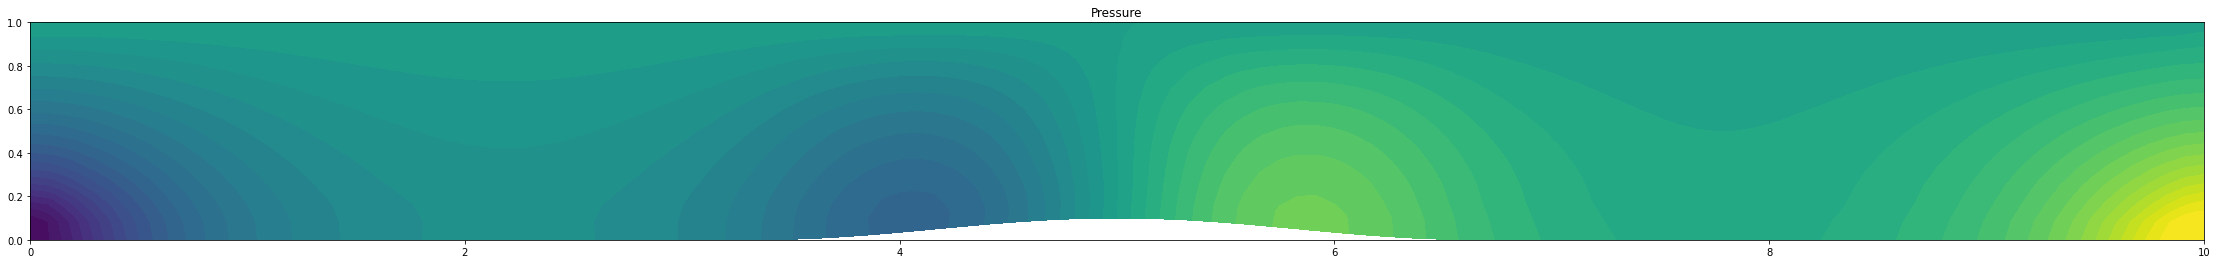

New Mesh:
Time t = 0.0091007971631813
0.9992582005301746 0.9994255924664293 0.9993449122107089 0.9993761899900001 0.9993958785095742 0.9994232845634703 0.9994529193030675 0.9994834776780049 0.9995139166293096 0.9995433223677841 0.9995711572552661 0.9995970884324749 0.99962096092736 0.999642745464052 0.9996624993446006 0.9996803336492723 0.999696391850931 0.9997108335994946 0.9997238240393065 0.9997355268611299 0.9997461000653688 0.9997556935844016 0.9997644481717944 0.9997724949085531 0.9997799548891655 0.9997869391374042 0.9997935481422024 0.99979987054754 0.9998059806008562 0.9998119341381543 0.9998177622230766 0.9998234605243915 0.9998289741527983 0.999834174756088 0.9998388277316776 0.9998425447277396 0.9998447135217673 0.9998443981095252 0.9998401429390333 0.9998297627297126 0.9998075945985304 0.9997680806803322 0.999714809211339 0.9996553475471617 0.9995943715121123 0.9995351900868964 0.9994803523285355 0.999431942851424 0.9993917062279314 0.9993611082868393 0.9993413607150737 0.

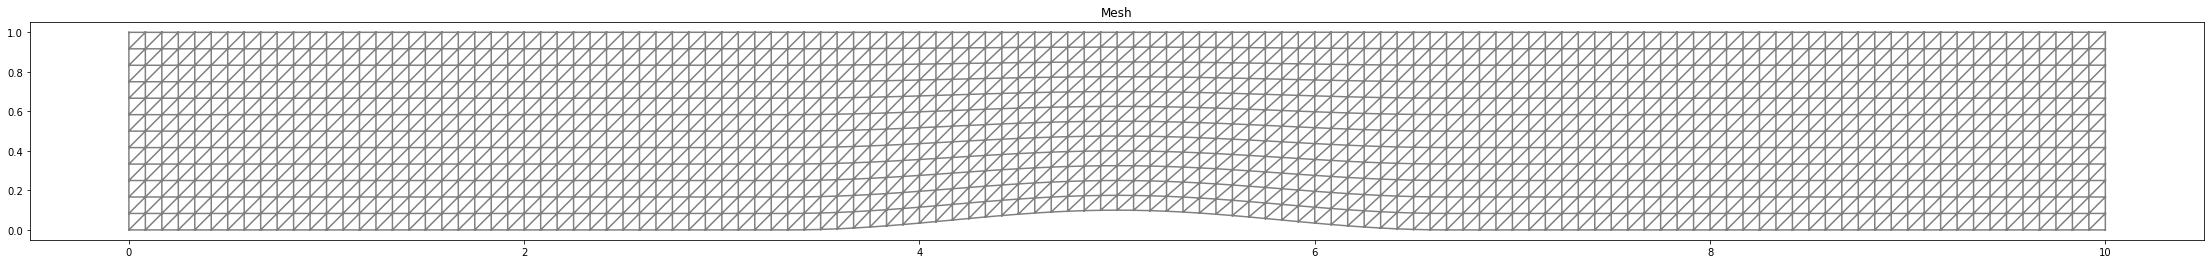

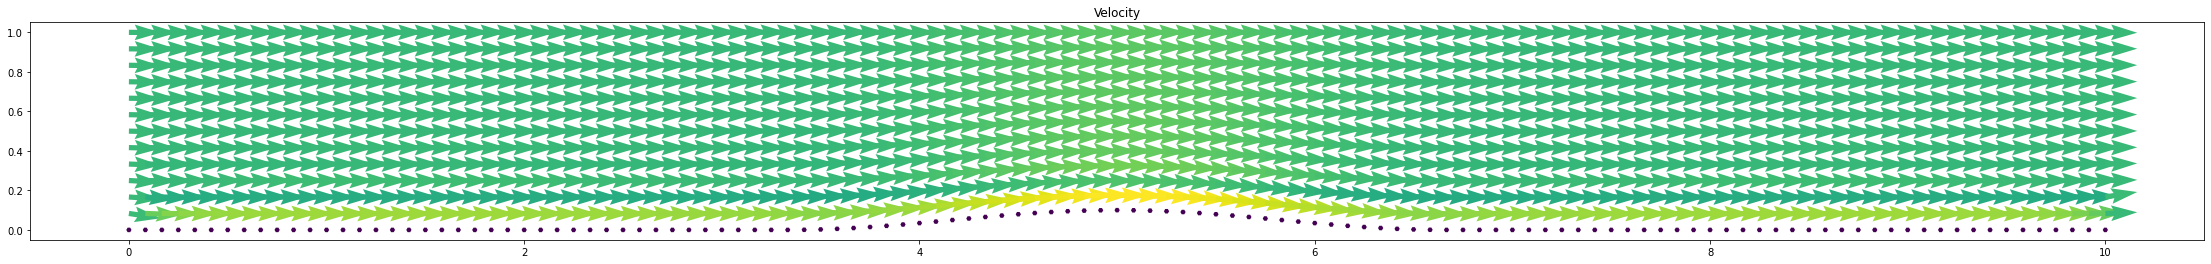

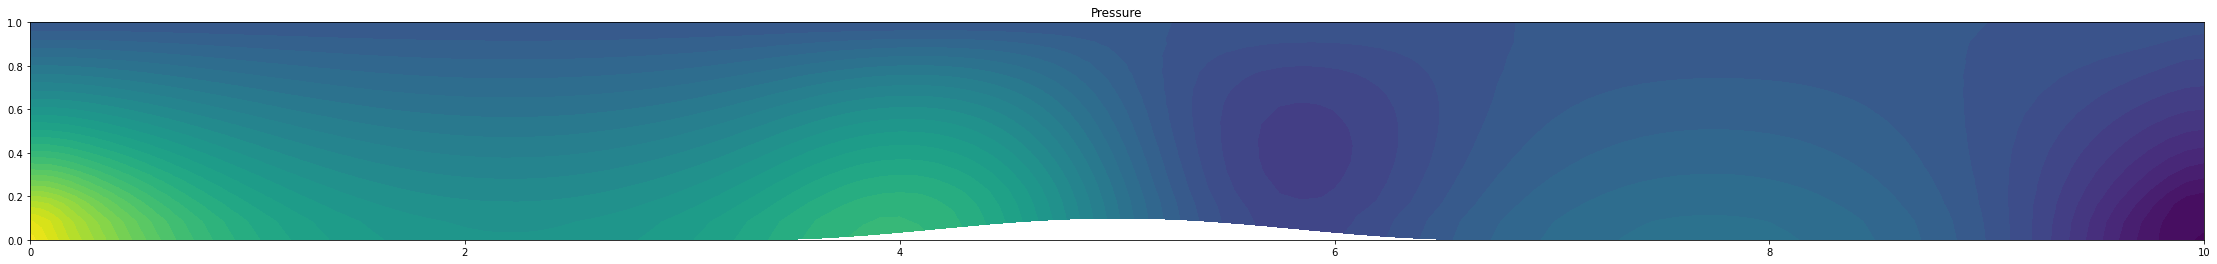

New Mesh:


KeyboardInterrupt: ignored

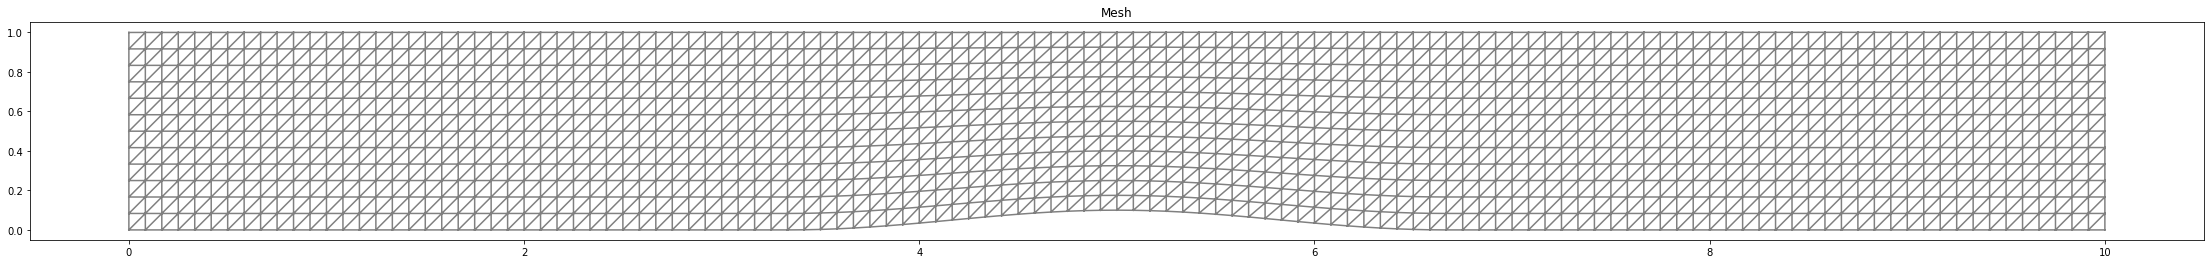

In [104]:
!rm results-NS/*

# apply initial conditions
if not closed:
    u0.interpolate(u_init)
    u1.interpolate(u_init)

print("Initial Pressure")
plt.figure(figsize=(40, 4))
plot(p1, title="Pressure")
print("===========")

print("Initial Velocity")
plt.figure(figsize=(40, 4))
plot(u1, title="Velocity")
print("===========")


# Time stepping
t = dt

def surface_node_compare(surface_node):
    return surface_node.position[0]

# used for boundary deformation scheme
class SurfaceNode():
    def __init__(self, mesh_index, position, u):
        self.mesh_index = mesh_index
        self.position = position
        self.velocity = u(position[0], position[1])

    def setup(self, surface):
        if self.index == 0:
            self.k = (self.position[1] - surface[1].position[1])/delta_x
        elif self.index == len(surface) - 1:
            self.k = (surface[-2].position[1] - self.position[1])/delta_x
        else:
            self.k = (surface[self.index + 1].position[1] - surface[self.index - 1].position[1])/(2*delta_x)

        self.k_scale = 1/sqrt(1 + self.k**2)
        self.delta_s = delta_x/self.k_scale
        self.n = [-self.k*self.k_scale, self.k_scale]
        self.Vdot = (self.n[0]*self.velocity[0] + self.n[1]*self.velocity[1])*self.delta_s*dt
        self.Vxdot = self.n[0]*self.Vdot
        self.Vydot = self.n[1]*self.Vdot
        self.W = self.Vydot/delta_x
        self.Wp = max(0, self.Vxdot/delta_x)
        self.Wm = max(0, -self.Vxdot/delta_x)

    def timestep(self, surface, boundary_coordinates):
        x = boundary_coordinates[self.mesh_index]
        x[1] += self.W
        if self.index != 0:
            x[1] += surface[self.index - 1].Wp
        elif closed:
            x[1] += self.Wm
        if self.index != len(surface) - 1:
            x[1] += surface[self.index + 1].Wm
        elif closed:
            x[1] += self.Wp
        else: # this builds on increasing update order
            x[1] = surface[self.index - 1].position[1]
        self.position = x

while t < T + DOLFIN_EPS:
    # extract the boundary mesh for the surface
    boundary = BoundaryMesh(mesh, "exterior", True)

    surface_nodes = []
    left_node_indices = []   # not including top
    right_node_indices = []  # not including top
    left_max = 0
    left_max_index = -1
    right_max = 0
    right_max_index = -1
    for i, x in enumerate(boundary.coordinates()):
        if lower.inside(x, True):
            pass
        elif left.inside(x, True):
            left_node_indices.append(i)
            if x[1] > left_max:
                left_max = x[1]
                left_max_index = i
        elif right.inside(x, True):
            right_node_indices.append(i)
            if x[1] > right_max:
                right_max = x[1]
                right_max_index = i
        else:
            surface_nodes.append(SurfaceNode(i, x, u1))
    surface_nodes.insert(0, SurfaceNode(left_max_index, [0.0, left_max], u1))
    surface_nodes.append(SurfaceNode(right_max_index, [L, right_max], u1))
    left_node_indices.remove(left_max_index)
    right_node_indices.remove(right_max_index)

    surface_nodes.sort(key=surface_node_compare)

    # displace surface boundary
    for i, node in enumerate(surface_nodes):
        node.index = i
    for node in surface_nodes:
        node.setup(surface_nodes)
    for node in surface_nodes:
        node.timestep(surface_nodes, boundary.coordinates())

    # deform edge boundary
    new_y_left = boundary.coordinates()[left_max_index][1]
    for j, i in enumerate(left_node_indices):
        x = boundary.coordinates()[i]
        positional_scale = x[1]/left_max
        x[1] = new_y_left*positional_scale
    new_y_right = boundary.coordinates()[right_max_index][1]
    for j, i in enumerate(right_node_indices):
        x = boundary.coordinates()[i]
        positional_scale = x[1]/right_max
        x[1] = new_y_right*positional_scale

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Add time
        if (t > start_sample_time):
          time = np.append(time, t)

        k += 1

    # Save solution to file at every time step
    file_u << u1
    file_p << p1

    if True or t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)

        # Plot solution
        plt.figure(figsize=(40, 4))
        plot(u1, title="Velocity")

        plt.figure(figsize=(40, 4))
        plot(p1, title="Pressure")

        for node in surface_nodes:
          print(str(node.position[1]) + " ", end="")
        print()
        
        plot_time += T/plot_freq
        
        plt.show()

    # reshape mesh
    w_new = ALE.move(mesh, boundary)
    w.set_md(w_new)
    uout.h = right_max
    uin.h = left_max
    # this supposedly helps to avoid crashing at solve
    mesh.bounding_box_tree().build(mesh)

    # show reshaped mesh
    print("New Mesh:")
    plt.figure(figsize=(40, 4))
    plot(mesh, title="Mesh")

    # Update time step
    u0.assign(u1)
    t += dt

In [ ]:

!tar -czvf results-NS.tar.gz results-NS
files.download('results-NS.tar.gz')